In [9]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/binnedFit_utilities.py

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d


In [2]:
pars = tfCube.getParams(redshift = 0.2)
pars['type_of_observation'] = 'slit'
# to make things practical during testing, increase the spaxel size.
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['nm_per_pixel'] = 0.025
pars['expTime'] = 10000.
pars['pixScale'] = 0.032
pars['Resolution'] = 5000
pars['sini'] = 1.
pars['aspect'] = 0.2
pars['vcirc'] = 200.
pars['area'] = 3.14*(1000./2.)**2
pars['linelist']['flux'][pars['linelist']['species'] == 'Halpha'] = 6e-24
pars['norm'] = 1e-26
pars['lambda_min'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] - 2
pars['lambda_max'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] + 2

pars['knot_fraction']=0.

lines = pars['linelist']
pars['half_light_radius'] = 0.5
#lines['flux'] = 1e-25 * 1e-9 # We seem to need another factor of 1e-9 here.
#pars['linelist'] = lines
pars['slitAngles'] = np.array([0.])#np.linspace(-np.pi/4., np.pi/2., 3)
pars['slitWidth']  = 0.02
pars['slitOffset'] = 0.0
# define some fiber parameters
#nfiber = 5
#r_off = 1.5
pars['fiber_size'] = 1.0
pars['psfFWHM'] = .06
pars['vscale'] = pars['half_light_radius']
pars['ngrid'] = 256
pars['image_size'] = 128

extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']

pars['add_continuum']=0

In [3]:
pars['vscale']

0.5

In [4]:
subGridPixScale

0.016

In [5]:
pars['ngrid']

256

In [6]:
aperture = galsim.Image(pars['ngrid'], pars['ngrid'],scale=subGridPixScale)

In [10]:

pars_more = pars.copy()
pars_more['lambda_min'] = pars['lambda_min']*0.8
pars_more['lambda_max'] = pars['lambda_max']*1.2
norm = pars['norm']

spec = tfCube.getGalaxySpectrum(pars_more,norm=norm)
specPh = tfCube.convertToPhotons(spec)

obsLambda = np.arange(pars['lambda_min'],pars['lambda_max'],pars['nm_per_pixel'])
specInterp = interp1d(specPh['lambda'],specPh['photonRate'],kind='slinear')
obsSpecPh = np.empty(specPh.size,dtype=[('lambda',np.float),('photonRate',np.float)])
obsSpecPh['lambda'] = specPh['lambda']
obsSpecPh['photonRate'] = ( specInterp(specPh['lambda'])*
                            pars['expTime']*pars['area']*
                            pars['throughput']*pars['pixScale']**2 *
                            pars['nm_per_pixel'] )
obsInterp = interp1d(obsSpecPh['lambda'],obsSpecPh['photonRate'],kind='slinear')

skySpec = ( tfCube.getSky(obsLambda, specPh) *
                pars['expTime']*pars['area']*
                pars['throughput']*
                pars['pixScale']**2 *
                pars['nm_per_pixel'])

In [11]:
# make the velocity field parameters
c_kms = 2.99792458e5 # c, in km/s
extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
grid1d = np.linspace(-extent/2.,extent/2.,pars['ngrid'])
xx,yy = np.meshgrid(grid1d, grid1d)
r = np.sqrt(xx**2 + yy**2)
theta = np.angle(xx+1j*yy)

In [12]:
# Generate the galaxy image that goes with this.
galIm,galObj,psf = tfCube.getGalaxySlice(pars)
lambda_1d = np.arange(pars['lambda_min'],pars['lambda_max'],pars['nm_per_pixel'])
fluxGrid = np.empty([pars['ngrid'],pars['ngrid'],obsLambda.size])
phi = tfCube.getPhi(theta,pars=pars)
v = pars['vcirc'] * np.arctan(r/pars['vscale']) * (2/ (np.pi * c_kms) )    
# v is actually in unit of redshift here ... 

### check velocity data cube in tfCube (in agreement with Miller13 arctan velocity curve)

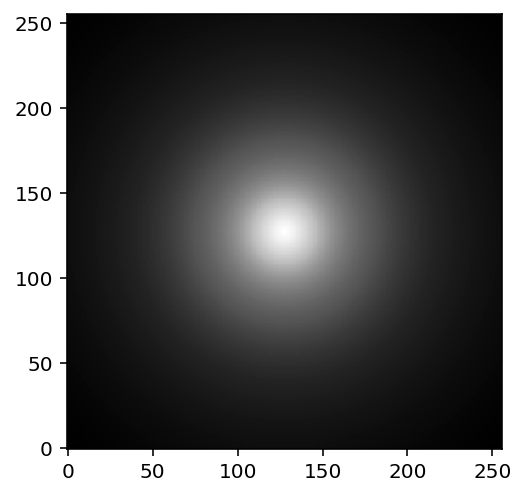

In [23]:
%matplotlib inline
plt.imshow(v*c_kms,cmap=plt.cm.Greys,origin="lower")

In [13]:
v_kms_1d = v[128,:]*c_kms
grid_pos = np.arange(-extent/2., extent/2., subGridPixScale)

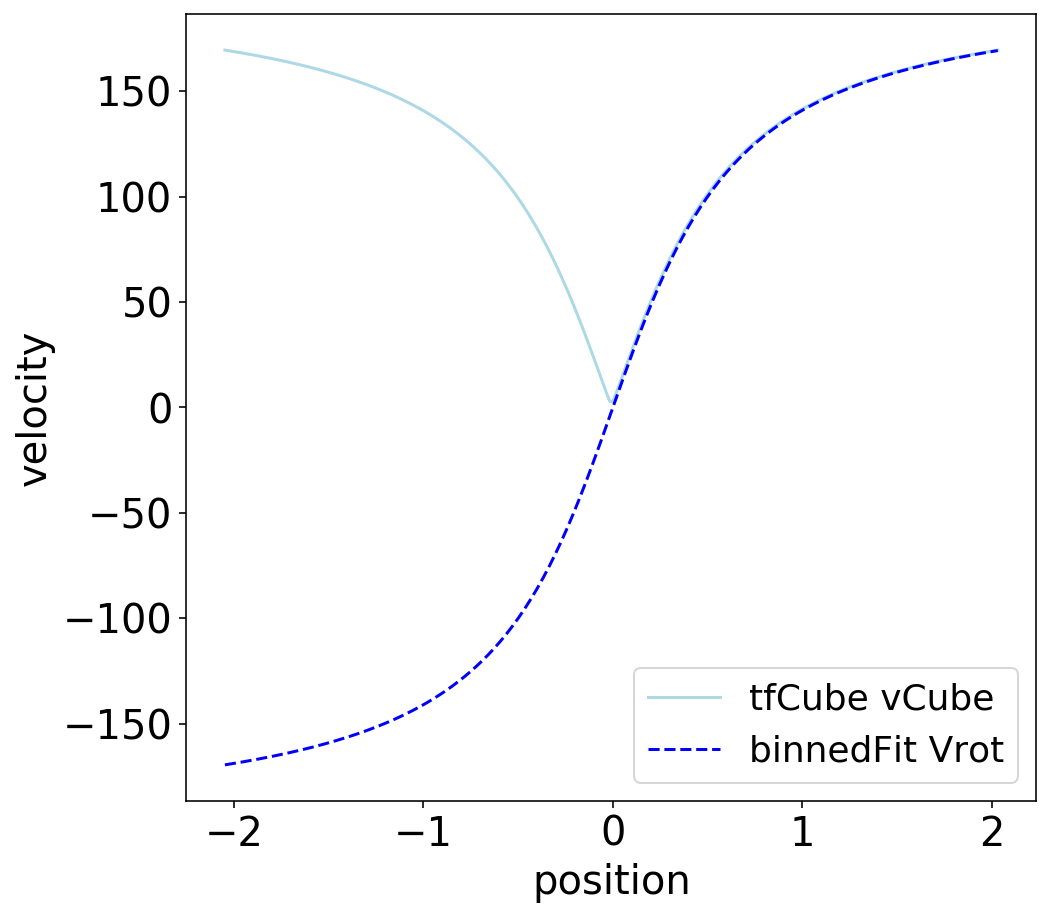

In [14]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, v_kms_1d, label='tfCube vCube', color='lightblue')

v_binnedFit = arctan_rotation(r=grid_pos, r_0=0., r_t=0.5, v_0=0., v_a=200.)
ax1.plot(grid_pos, v_binnedFit, label='binnedFit Vrot', color='b',ls='--')


ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

In [15]:
for i,x in enumerate(grid1d):
    for j,y in enumerate(grid1d):
        # This line here is where the disk velocity field enters.
        thisLambda = 1./(1 +   v[i,j] *pars['sini']*np.cos(phi[i,j])) * obsLambda
        thisSpec = obsInterp(thisLambda)*galIm.array[i,j] # this is the unsheared thing.
        fluxGrid[i,j,:] = thisSpec # currently in units of photon flux
# Shear the results and project them onto the output grid.
idealGrid = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
obsGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])
skyGrid   = np.empty([aperture.array.shape[0],aperture.array.shape[1],obsLambda.size])

psf = psf.shear(g1=pars['psf_g1'],g2 = pars['psf_g2'])
#psf = psf.dilate(1.02)
psfInv = galsim.Deconvolve(psf)

In [16]:
pars['sini']

1.0

### check at the major axes direction cos(phi)

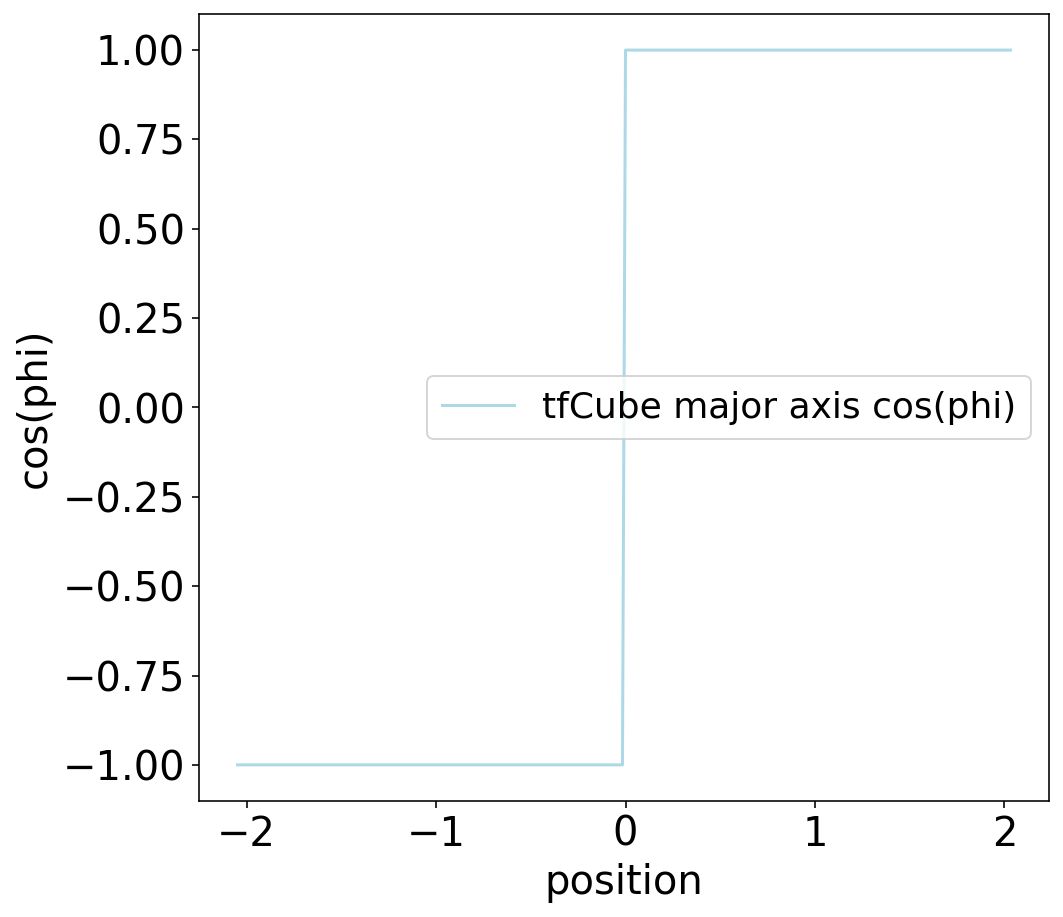

In [35]:

%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, np.cos(phi[128,:]), label='tfCube major axis cos(phi)', color='lightblue')

ax1.set_xlabel('position')
ax1.set_ylabel('cos(phi)')

ax1.legend(loc='best',prop={'size':18})

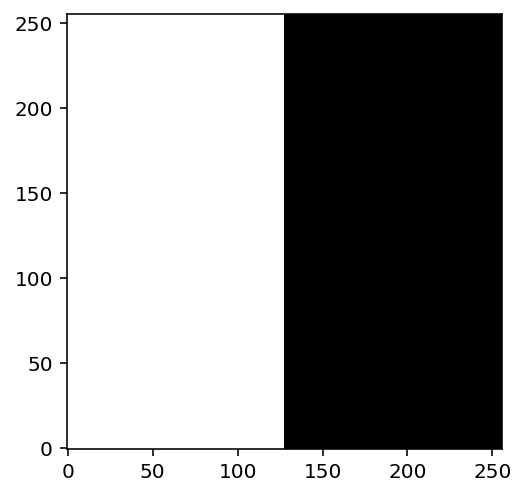

In [36]:
%matplotlib inline
plt.imshow(np.cos(phi),cmap=plt.cm.Greys,origin="lower")

In [17]:
redshift_2D_map = v *pars['sini']*np.cos(phi)

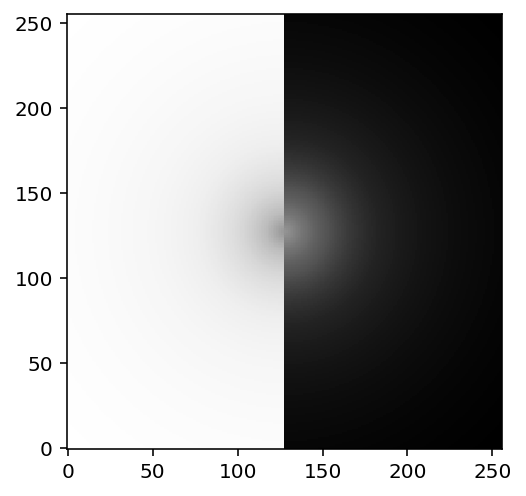

In [19]:
%matplotlib inline
plt.imshow(redshift_2D_map,cmap=plt.cm.Greys,origin="lower")

In [53]:
%matplotlib qt5
plt.imshow(redshift_2D_map*c_kms,cmap=plt.cm.Greys,origin="lower")

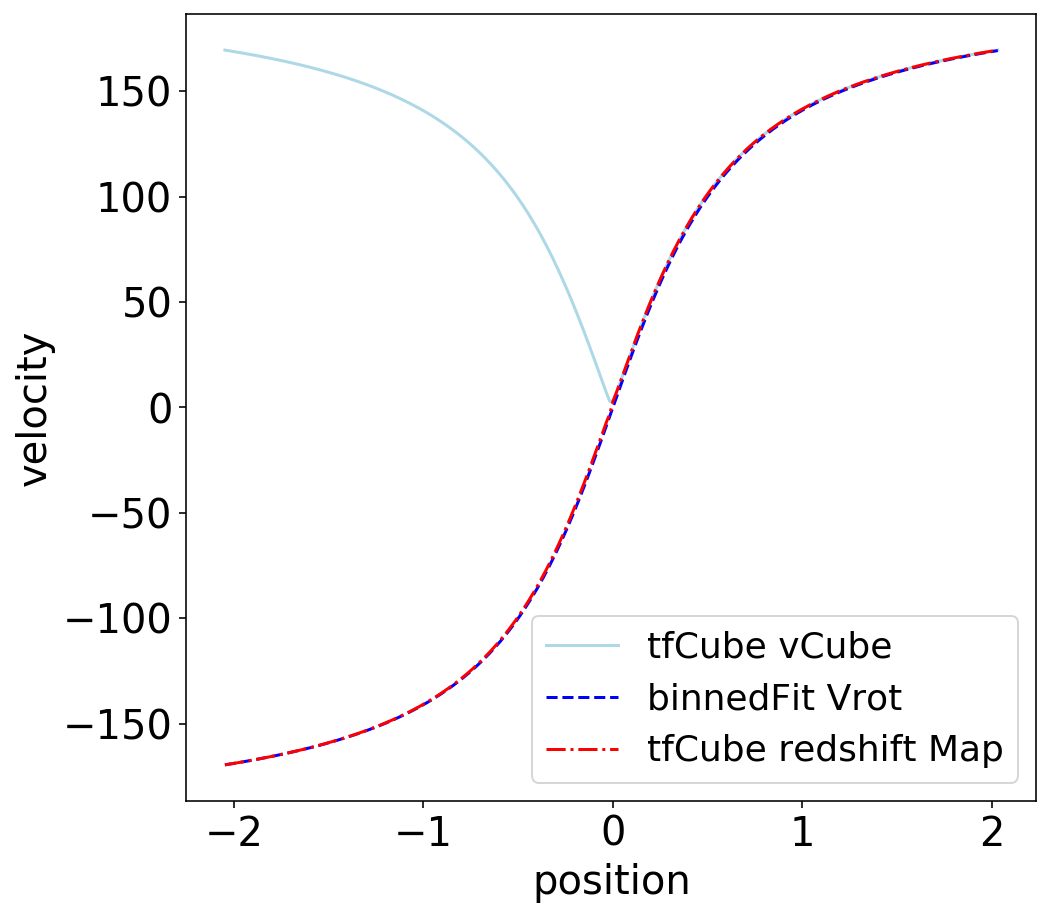

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, v_kms_1d, label='tfCube vCube', color='lightblue')

v_binnedFit = arctan_rotation(r=grid_pos, r_0=0., r_t=0.5, v_0=0., v_a=200.)
ax1.plot(grid_pos, v_binnedFit, label='binnedFit Vrot', color='b',ls='--')

ax1.plot(grid_pos, redshift_2D_map[128,:]*c_kms, label='tfCube redshift Map', color='r',ls='-.')
#ax1.plot(grid_pos, redshift_2D_map[:,128]*c_kms, label='tfCube redshift Map', color='r',ls='-.')
#ax1.plot(grid_pos, redshift_2D_map[:,127]*c_kms, label='tfCube redshift Map', color='r',ls='-.')


ax1.set_xlabel('position')
ax1.set_ylabel('velocity')

ax1.legend(loc='best',prop={'size':18})

In [32]:
xx[128,:]

array([-2.048     , -2.03193725, -2.01587451, -1.99981176, -1.98374902,
       -1.96768627, -1.95162353, -1.93556078, -1.91949804, -1.90343529,
       -1.88737255, -1.8713098 , -1.85524706, -1.83918431, -1.82312157,
       -1.80705882, -1.79099608, -1.77493333, -1.75887059, -1.74280784,
       -1.7267451 , -1.71068235, -1.69461961, -1.67855686, -1.66249412,
       -1.64643137, -1.63036863, -1.61430588, -1.59824314, -1.58218039,
       -1.56611765, -1.5500549 , -1.53399216, -1.51792941, -1.50186667,
       -1.48580392, -1.46974118, -1.45367843, -1.43761569, -1.42155294,
       -1.4054902 , -1.38942745, -1.37336471, -1.35730196, -1.34123922,
       -1.32517647, -1.30911373, -1.29305098, -1.27698824, -1.26092549,
       -1.24486275, -1.2288    , -1.21273725, -1.19667451, -1.18061176,
       -1.16454902, -1.14848627, -1.13242353, -1.11636078, -1.10029804,
       -1.08423529, -1.06817255, -1.0521098 , -1.03604706, -1.01998431,
       -1.00392157, -0.98785882, -0.97179608, -0.95573333, -0.93

In [33]:
yy[128,:]

array([0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803137,
       0.00803137, 0.00803137, 0.00803137, 0.00803137, 0.00803

In [ ]:
### check galIm

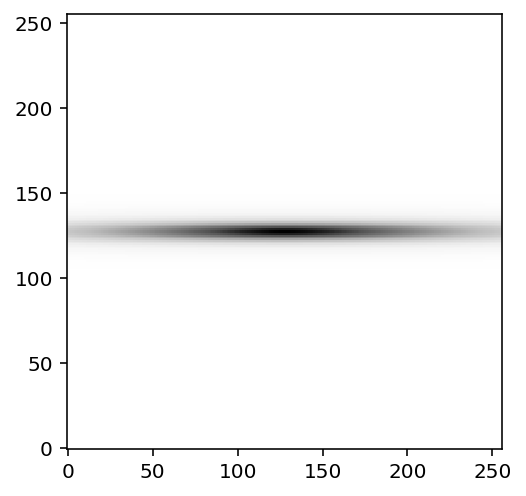

In [37]:
%matplotlib inline
plt.imshow(galIm.array,cmap=plt.cm.Greys,origin="lower")

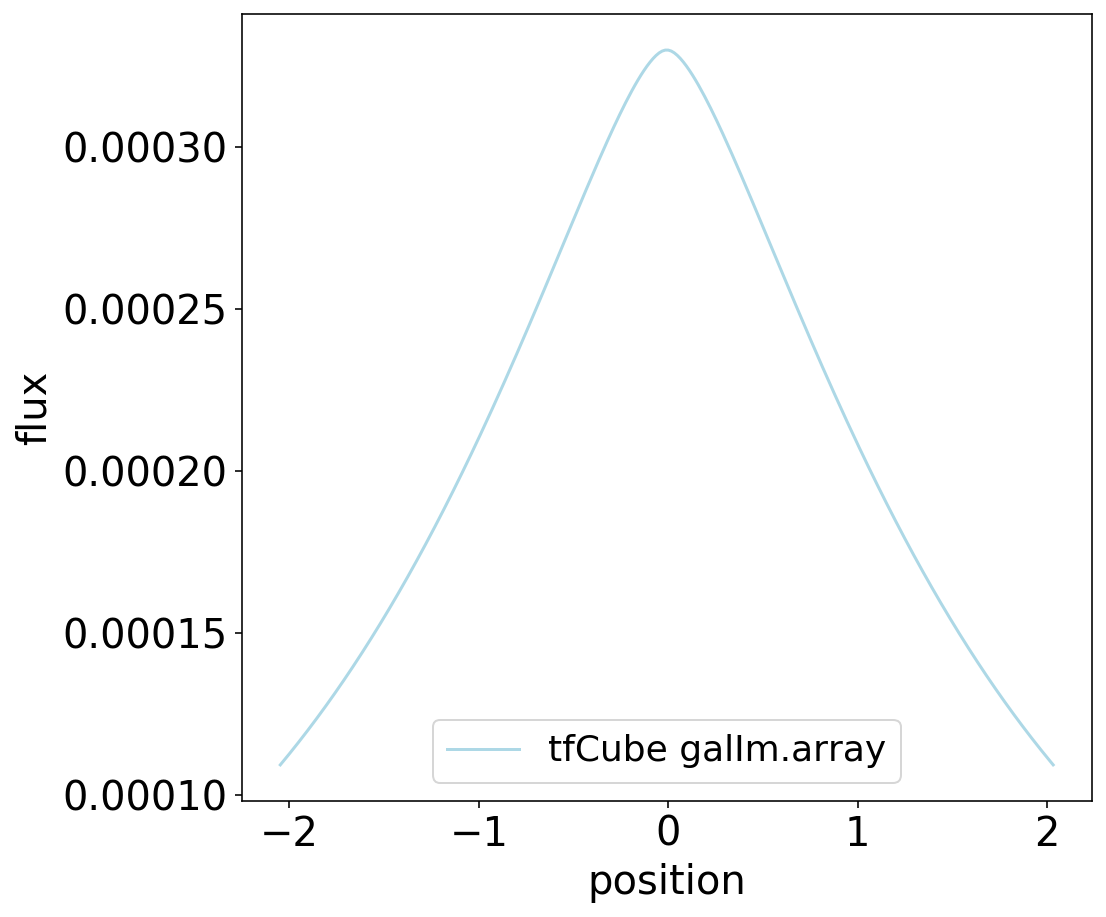

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(7.2,6.5))
plt.rc('font',size=20)

ax1=fig.add_axes([0.16,0.11,0.82,0.84])

ax1.plot(grid_pos, galIm.array[128,:], label='tfCube galIm.array', color='lightblue')

ax1.set_xlabel('position')
ax1.set_ylabel('flux')

ax1.legend(loc='best',prop={'size':18})